### Modeling DAU with Markov Chain

Doubtlessly, **DAU**, **WAU**, and **MAU** — daily, weekly, and monthly active users — are critical business metrics. Cost estimations often require DAU forecasts.

Prediction using Duolingo’s growth model - this approach is better compared to standard time-series forecasting methods, and can be adjusted the prediction according to your teams' plans (e.g., marketing, activation, product teams).

#### Methodology

A quick recap on how the [Duolingo’s growth model](https://blog.duolingo.com/growth-model-duolingo/) works. At day d (d = 1, 2, … ) of a user’s lifetime, the user can be in one of the following 7 (mutually-exclusive) states: `new`, `current`, `reactivated`, `resurrected`, `at_risk_wau`, `at_risk_mau`, `dormant`. The states are defined according to indicators of whether a user was active today, in the last 7 days, or in the last 30 days.

Having these states defined (as a set `S`), we can consider user behavior as a `Markov chain`. Here’s an example of a user’s trajectory: `new→ current→ current→ at_risk_wau→...→ at_risk_mau→...→ dormant`. Let M be a transition matrix associated with this Markov process: `m_{i, j} = P(s_j | s_i)` are the probabilities that a user moves to state `s_j` right after being at state `s_i`, where `s_i, s_j ∈ S`. Such a matrix is inferred from the historical data.

#### Implementation and Dataset

A simulated dataset based on historical data of a SaaS app is being used. The data is stored in the [dau_data.csv.gz](/data/dau_data.csv.gz) file and contains three columns: `user_id`, `date`, and `registration_date`. Each record indicates a day when a user was active. The dataset includes activity indicators for *51480* users from *2020-11-01* to *2023-10-31*. Additionally, data from October 2020 is included to calculate user states properly, as the `at_risk_mau` and `dormant` states require data from one month prior.

In [1]:
import pandas as pd

df = pd.read_csv('data/dau_data.csv.gz', compression='gzip')
df['date'] = pd.to_datetime(df['date'])
df['registration_date'] = pd.to_datetime(df['registration_date'])

print(f'Shape: {df.shape}')
print(f'Total users: {df['user_id'].nunique()}')
print(f'Data range: [{df['date'].min()}, {df['date'].max()}]')

Shape: (667236, 3)
Total users: 51480
Data range: [2020-10-01 00:00:00, 2023-10-31 00:00:00]


In [2]:
df.head()

,user_id,date,registration_date
0,d8c465ab-e9fd-5edd-9e4e-c77094700cb5,2020-10-01,2020-08-25
1,269b7f13-a509-5174-85cb-95a8f7b932e8,2020-10-01,2020-08-25
2,bfeac474-5b66-566f-8654-262bb79c873e,2020-10-01,2020-05-31
3,d32fcac5-122c-5463-8aea-01b39b9ad0bb,2020-10-01,2020-09-30
4,c1ece677-e643-5bb3-8701-f1c59a0bf4cd,2020-10-01,2020-09-05


#### Daily Active Users (DAU) time-series

<Axes: title={'center': 'DAU, historical'}, xlabel='date'>

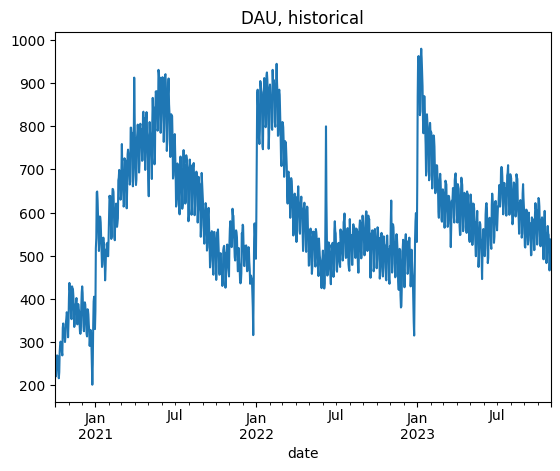

In [3]:
df.groupby('date').size().plot(title='DAU, historical')

#### Predicting the DAU metric for the next 2024 year

In [4]:
PREDICTION_START = '2023-11-01'
PREDICTION_END = '2024-12-31'

#### Predicting new users amount

In [5]:
new_users = df[df['date'] == df['registration_date']].groupby('date').size()
new_users.head()

date
2020-10-01    4
2020-10-02    4
2020-10-03    3
2020-10-04    4
2020-10-05    8
dtype: int64

In [6]:
import logging
import matplotlib.pyplot as plt
from prophet import Prophet

# suppress prophet logs
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').disabled=True

def predict_new_users(prediction_start, prediction_end, new_users_train, show_plot=True):
    """
    Forecasts a time-seires for new users

    Parameters
    ----------
    prediction_start : str
        Date in YYYY-MM-DD format.
    prediction_end : str
        Date in YYYY-MM-DD format.
    new_users_train : pandas.Series
        Historical data for the time-series preceding the prediction period.
    show_plot : boolean, default=True
        If True, a chart with the train and predicted time-series values is displayed.
    Returns
    -------
    pandas.Series
        Series containing the predicted values.
    """
    m = Prophet()

    new_users_train = new_users_train\
        .loc[new_users_train.index < prediction_start]
    new_users_prophet = pd.DataFrame({
        'ds': new_users_train.index,
        'y': new_users_train.values
    })

    m.fit(new_users_prophet)

    periods = len(pd.date_range(prediction_start, prediction_end))
    future = m.make_future_dataframe(periods=periods)
    new_users_pred = m.predict(future)
    if show_plot:
        m.plot(new_users_pred)
        plt.title('New users prediction');

    new_users_pred = new_users_pred\
        .assign(yhat=lambda _df: _df['yhat'].astype(int))\
        .rename(columns={'ds': 'date', 'yhat': 'count'})\
        .set_index('date')\
        .clip(lower=0)\
        ['count']

    return new_users_pred

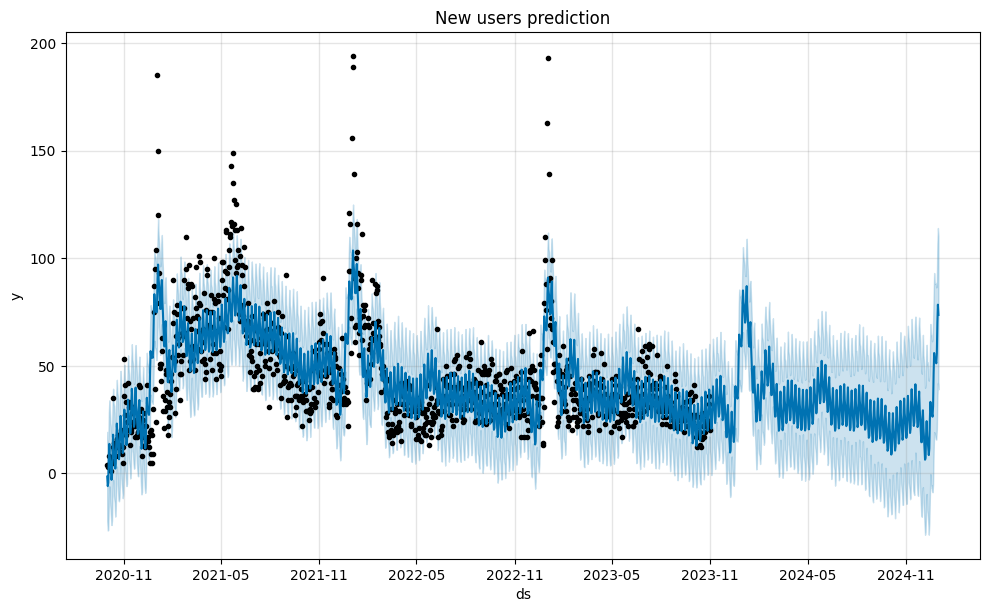

In [7]:
new_users_pred = predict_new_users(PREDICTION_START, PREDICTION_END, new_users)

In [8]:
new_users_pred.tail(5)

date
2024-12-27    51
2024-12-28    55
2024-12-29    70
2024-12-30    78
2024-12-31    73
Name: count, dtype: int64

#### Getting the states

Assign one of the 7 states to each day of a user’s lifetime within the app. According to the definition, for each day, consider at least 
the past 30 days. This is where SQL window functions come in. H- owever, since the df data contains only records of active days, we need to explicitly extend them and include the days when a user was not active.

For readability purposes, the following SQL query is split into multiple subqueries.

- **`full_range`**: Create a full sequence of dates for each user.

- **`dau_full`**: Get the full list of both active and inactive records.

- **`states`**: Assign one of the 7 states for each day of a user's lifetime.

In [9]:
import duckdb

DATASET_START = '2020-11-01'
DATASET_END = '2023-10-31'
OBSERVATION_START = '2020-10-01'

query = f"""
WITH
full_range AS (
    SELECT
        user_id, UNNEST(generate_series(greatest(registration_date, '{OBSERVATION_START}'), date '{DATASET_END}', INTERVAL 1 DAY))::date AS date
    FROM (
        SELECT DISTINCT user_id, registration_date FROM df
    )
),
dau_full AS (
    SELECT
        fr.user_id,
        fr.date,
        df.date IS NOT NULL AS is_active,
        registration_date
    FROM full_range AS fr
    LEFT JOIN df USING(user_id, date)
),
states AS (
    SELECT
        user_id,
        date,
        is_active,
        first_value(registration_date IGNORE NULLS) OVER (PARTITION BY user_id ORDER BY date) AS registration_date,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 6 PRECEDING and 1 PRECEDING) AS active_days_back_6d,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 29 PRECEDING and 1 PRECEDING) AS active_days_back_29d,
        CASE
            WHEN date = registration_date THEN 'new'
            WHEN is_active = TRUE AND active_days_back_6d BETWEEN 1 and 6 THEN 'current'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) > 0 THEN 'reactivated'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) = 0 THEN 'resurrected'
            WHEN is_active = FALSE AND active_days_back_6d > 0 THEN 'at_risk_wau'
            WHEN is_active = FALSE AND active_days_back_6d = 0 AND ifnull(active_days_back_29d, 0) > 0 THEN 'at_risk_mau'
            ELSE 'dormant'
        END AS state
    FROM dau_full
)
SELECT user_id, date, state FROM states
WHERE date BETWEEN '{DATASET_START}' AND '{DATASET_END}'
ORDER BY user_id, date
"""
states = duckdb.sql(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
states.head()

,user_id,date,state
0,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-23,new
1,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-24,current
2,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-25,current
3,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-26,current
4,00002b68-adba-5a55-92d7-8ea8934c6db3,2023-06-27,current


#### Calculating the transition matrix

Having obtained these states, the state transition frequencies can be calculated. The resulting transitions `DataFrame` contains `date`, `state_from`, `state_to`, and `cnt` columns.

In [11]:
query = f"""
SELECT
    date,
    state_from,
    state_to,
    COUNT(*) AS cnt,
FROM (
    SELECT
        date,
        state AS state_to,
        lag(state) OVER (PARTITION BY user_id ORDER BY date) AS state_from
    FROM states
)
WHERE state_from IS NOT NULL
GROUP BY date, state_from, state_to
ORDER BY date, state_from, state_to;
"""
transitions = duckdb.sql(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
transitions.head()

,date,state_from,state_to,cnt
0,2020-11-02,at_risk_mau,at_risk_mau,273
1,2020-11-02,at_risk_mau,dormant,4
2,2020-11-02,at_risk_mau,reactivated,14
3,2020-11-02,at_risk_wau,at_risk_mau,18
4,2020-11-02,at_risk_wau,at_risk_wau,138


In [13]:
states_order = ['new', 'current', 'reactivated', 'resurrected', 'at_risk_wau', 'at_risk_mau', 'dormant']

def get_transition_matrix(transitions, date1, date2):
    if pd.to_datetime(date1) > pd.to_datetime(DATASET_END):
        date1 = pd.to_datetime(DATASET_END) - pd.Timedelta(days=30)

    probs = transitions\
        .loc[lambda _df: _df['date'].between(date1, date2)]\
        .groupby(['state_from', 'state_to'], as_index=False)\
        ['cnt'].sum()\
        .assign(
            supp=lambda _df: _df.groupby('state_from')['cnt'].transform('sum'),
            prob=lambda _df: _df['cnt'] / _df['supp']
        )

    M = probs.pivot(index='state_from', columns='state_to', values='prob')\
        .reindex(states_order, axis=0)\
        .reindex(states_order, axis=1)\
        .fillna(0)\
        .astype(float)

    return M

In [14]:
M = get_transition_matrix(transitions, '2022-11-01', '2023-10-31')

M

state_to,new,current,reactivated,resurrected,at_risk_wau,at_risk_mau,dormant
state_from,,,,,,,
new,0.0,0.515934,0.000000,0.000000,0.484066,0.000000,0.000000
current,0.0,0.851325,0.000000,0.000000,0.148675,0.000000,0.000000
reactivated,0.0,0.365867,0.000000,0.000000,0.634133,0.000000,0.000000
resurrected,0.0,0.316474,0.000000,0.000000,0.683526,0.000000,0.000000
at_risk_wau,0.0,0.098246,0.004472,0.000000,0.766263,0.131020,0.000000
at_risk_mau,0.0,0.000000,0.009598,0.000173,0.000000,0.950109,0.040120
dormant,0.0,0.000000,0.000000,0.000387,0.000000,0.000000,0.999613


In [15]:
def get_state0(date):
    query = f"""
    SELECT state, count(*) AS cnt
    FROM states
    WHERE date = '{date}'
    GROUP BY state
    """

    state0 = duckdb.sql(query).df()
    state0 = state0.set_index('state').reindex(states_order)['cnt']
    
    return state0

In [16]:
state0 = get_state0(DATASET_END)
state0

state
new               20
current          475
reactivated       15
resurrected       19
at_risk_wau      404
at_risk_mau     1024
dormant        49523
Name: cnt, dtype: int64

#### Predicting DAU

The `predict_dau` function below accepts all the previous variables required for the DAU prediction and makes this prediction for a date range defined by the `start_date` and `end_date` arguments.

In [17]:
def predict_dau(M, state0, start_date, end_date, new_users):
    """
    Predicts DAU over a given date range.

    Parameters
    ----------
    M : pandas.DataFrame
        Transition matrix representing user state changes.
    state0 : pandas.Series
        counts of initial state of users.
    start_date : str
        Start date of the prediction period in 'YYYY-MM-DD' format.
    end_date : str
        End date of the prediction period in 'YYYY-MM-DD' format.
    new_users : int or pandas.Series
        The expected amount of new users for each day between `start_date` and `end_date`.
        If a Series, it should have dates as the index.
        If an int, the same number is used for each day.
        
    Returns
    -------
    pandas.DataFrame
        DataFrame containing the predicted DAU, WAU, and MAU for each day in the date range,
        with columns for different user states and tot.
    """
    
    dates = pd.date_range(start_date, end_date)
    dates.name = 'date'
    dau_pred = []
    new_dau = state0.copy()
    for date in dates:
        new_dau = (M.transpose() @ new_dau).astype(int)
        if isinstance(new_users, int):
            new_users_today = new_users
        else:
            new_users_today = new_users.astype(int).loc[date] 
        new_dau.loc['new'] = new_users_today
        dau_pred.append(new_dau.tolist())

    dau_pred = pd.DataFrame(dau_pred, index=dates, columns=states_order)
    dau_pred['dau'] = dau_pred['new'] + dau_pred['current'] + dau_pred['reactivated'] + dau_pred['resurrected']
    dau_pred['wau'] = dau_pred['dau'] + dau_pred['at_risk_wau']
    dau_pred['mau'] = dau_pred['dau'] + dau_pred['at_risk_wau'] + dau_pred['at_risk_mau']
    
    return dau_pred

In [18]:
dau_pred = predict_dau(M, state0, PREDICTION_START, PREDICTION_END, new_users_pred)
dau_pred

,new,current,reactivated,resurrected,at_risk_wau,at_risk_mau,dormant,dau,wau,mau
date,,,,,,,,,,
2023-11-01,29,465,11,19,412,1025,49544,524,936,1961
2023-11-02,25,461,11,19,418,1027,49565,516,934,1961
2023-11-03,20,456,11,19,420,1030,49587,506,926,1956
2023-11-04,22,449,11,19,419,1033,49609,501,920,1953
2023-11-05,34,444,11,19,418,1036,49631,508,926,1962
...,...,...,...,...,...,...,...,...,...,...
2024-12-27,51,494,12,23,477,1102,61366,580,1057,2159
2024-12-28,55,505,12,23,486,1109,61386,595,1081,2190
2024-12-29,70,517,12,23,497,1117,61406,622,1119,2236


Besides the expected DAU, WAU, and MAU columns, the output contains the number of users in each state for each prediction date.

Finally, we calculate the ground-truth values of DAU, WAU, and MAU (along with the user state counts), keep them in the `dau_true` DataFrame, and plot the predicted and true values altogether.

In [19]:
query = f"""
SELECT date, state, COUNT(*) AS cnt
FROM states
GROUP BY date, state
ORDER BY date, state;
"""

dau_true = duckdb.sql(query).df()
dau_true['date'] = pd.to_datetime(dau_true['date'])
dau_true = dau_true.pivot(index='date', columns='state', values='cnt')
dau_true['dau'] = dau_true['new'] + dau_true['current'] + dau_true['reactivated'] + dau_true['resurrected']
dau_true['wau'] = dau_true['dau'] + dau_true['at_risk_wau']
dau_true['mau'] = dau_true['dau'] + dau_true['at_risk_wau'] + dau_true['at_risk_mau']

In [20]:
dau_true.head()

state,at_risk_mau,at_risk_wau,current,dormant,new,reactivated,resurrected,dau,wau,mau
date,,,,,,,,,,
2020-11-01,291.0,207.0,293.0,840.0,36.0,14.0,3.0,346.0,553.0,844.0
2020-11-02,291.0,208.0,327.0,836.0,53.0,14.0,8.0,402.0,610.0,901.0
2020-11-03,296.0,205.0,383.0,840.0,41.0,10.0,3.0,437.0,642.0,938.0
2020-11-04,296.0,246.0,375.0,842.0,27.0,13.0,6.0,421.0,667.0,963.0
2020-11-05,300.0,275.0,373.0,845.0,33.0,8.0,4.0,418.0,693.0,993.0


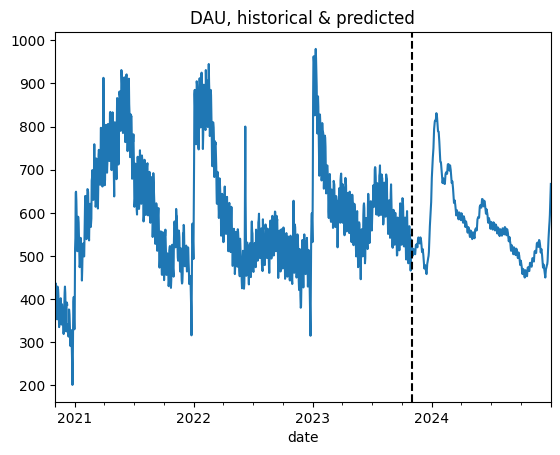

In [21]:
pd.concat([dau_true['dau'], dau_pred['dau']]).plot(title='DAU, historical & predicted');
plt.axvline(PREDICTION_START, color='k', linestyle='--');

#### Model evaluation

In [22]:
def predict_dau_prophet(prediction_start, prediction_end, dau_true, show_plot=True):
    # assigning peak days for the new year
    holidays = pd.DataFrame({
        'holiday': 'january_spike',
        'ds': pd.date_range('2022-01-01', '2022-01-31', freq='D').tolist() + \
              pd.date_range('2023-01-01', '2023-01-31', freq='D').tolist(),
        'lower_window': 0,
        'upper_window': 40
    })

    m = Prophet(growth='logistic', holidays=holidays)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=3)
    m.add_seasonality(name='yearly', period=365, fourier_order=3)

    train = dau_true.loc[(dau_true.index < prediction_start) & (dau_true.index >= '2021-08-01')]
    train_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    # removining outliers
    train_prophet.loc[train_prophet['ds'].between('2022-06-07', '2022-06-09'), 'y'] = None
    train_prophet['new_year_peak'] = (train_prophet['ds'] >= '2022-01-01') &\
                                     (train_prophet['ds'] <= '2022-02-14')
    m.add_regressor('new_year_peak')
    # setting logistic upper and lower bounds
    train_prophet['cap'] = dau_true.max() * 1.1
    train_prophet['floor'] = 0

    m.fit(train_prophet)

    periods = len(pd.date_range(prediction_start, prediction_end))
    future = m.make_future_dataframe(periods=periods)
    future['new_year_peak'] = (future['ds'] >= '2022-01-01') & (future['ds'] <= '2022-02-14')
    future['cap'] = dau_true.max() * 1.1
    future['floor'] = 0
    pred = m.predict(future)

    if show_plot:
        m.plot(pred);

    # converting the predictions to an appropriate format
    pred = pred\
        .assign(yhat=lambda _df: _df['yhat'].astype(int))\
        .rename(columns={'ds': 'date', 'yhat': 'count'})\
        .set_index('date')\
        .clip(lower=0)\
        ['count']\
        .loc[lambda s: (s.index >= prediction_start) & (s.index <= prediction_end)]

    return pred

Test a prediction for multiple predicting horizons: 3, 6, and 12 months. As a result, we get 3 test sets:

- 3-months horizon: `2023-08-01` - `2023-10-31`,

- 6-months horizon: `2023-05-01` - `2023-10-31`,

- 1-year horizon: `2022-11-01` - `2023-10-31`.

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

mapes = []
prediction_end = '2023-10-31'
prediction_horizon = [3, 6, 12]

for offset in prediction_horizon:
    prediction_start = pd.to_datetime(prediction_end) - pd.DateOffset(months=offset - 1)
    prediction_start = prediction_start.replace(day=1)
    prediction_end = '2023-10-31'
    pred = predict_dau_prophet(prediction_start, prediction_end, dau_true['dau'], show_plot=False)
    mape = mean_absolute_percentage_error(dau_true['dau'].reindex(pred.index), pred)
    mapes.append(mape)

mapes = pd.DataFrame({'horizon': prediction_horizon, 'MAPE': mapes})
mapes

,horizon,MAPE
0,3,0.521765
1,6,0.184127
2,12,3.351667


The `MAPE error` turns out to be high: 18% — 52%. The fact that the shortest horizon has the highest error means that the model is tuned for the long-term predictions.

The `make_predicion` helper function below implements the described options. It accepts `prediction_start`, `prediction_end` arguments defining the prediction period for a given horizon, `new_users_mode` which can be either `true` or `predict`, and `transition_period`. The options of the latter argument will be explained further.

In [24]:
import re


def make_prediction(prediction_start, prediction_end, new_users_mode='predict', transition_period='last_30d'):
    prediction_start_minus_1d = pd.to_datetime(prediction_start) - pd.Timedelta('1d')
    state0 = get_state0(prediction_start_minus_1d)
    
    if new_users_mode == 'predict':
        new_users_pred = predict_new_users(prediction_start, prediction_end, new_users, show_plot=False)
    elif new_users_mode == 'true':
        new_users_pred = new_users.copy()

    if transition_period.startswith('last_'):
        shift = int(re.search(r'last_(\d+)d', transition_period).group(1))
        transitions_start = pd.to_datetime(prediction_start) - pd.Timedelta(shift, 'd')
        M = get_transition_matrix(transitions, transitions_start, prediction_start_minus_1d)
        dau_pred = predict_dau(M, state0, prediction_start, prediction_end, new_users_pred)
    else:
        transitions_start = pd.to_datetime(prediction_start) - pd.Timedelta(240, 'd')
        M_base = get_transition_matrix(transitions, transitions_start, prediction_start_minus_1d)
        dau_pred = pd.DataFrame()

        month_starts = pd.date_range(prediction_start, prediction_end, freq='1MS')
        N = len(month_starts)

        for i, prediction_month_start in enumerate(month_starts):
            prediction_month_end = pd.offsets.MonthEnd().rollforward(prediction_month_start)
            transitions_month_start = prediction_month_start - pd.Timedelta('365D')
            transitions_month_end = prediction_month_end - pd.Timedelta('365D')

            M_seasonal = get_transition_matrix(transitions, transitions_month_start, transitions_month_end)
            if transition_period == 'smoothing':
                i = min(i, 12)
                M = M_seasonal * i / (N - 1)  + (1 - i / (N - 1)) * M_base
            elif transition_period.startswith('seasonal_'):
                seasonal_coef = float(re.search(r'seasonal_(0\.\d+)', transition_period).group(1))
                M = seasonal_coef * M_seasonal + (1 - seasonal_coef) * M_base
            
            dau_tmp = predict_dau(M, state0, prediction_month_start, prediction_month_end, new_users_pred)
            dau_pred = pd.concat([dau_pred, dau_tmp])

            state0 = dau_tmp.loc[prediction_month_end][states_order]

    return dau_pred

def prediction_details(dau_true, dau_pred, show_plot=True, ax=None):
    y_true = dau_true.reindex(dau_pred.index)['dau']
    y_pred = dau_pred['dau']
    mape = mean_absolute_percentage_error(y_true, y_pred) 

    if show_plot:
        prediction_start = str(y_true.index.min().date())
        prediction_end = str(y_true.index.max().date())
        if ax is None:
            y_true.plot(label='DAU true')
            y_pred.plot(label='DAU pred')
            plt.title(f'DAU prediction, {prediction_start} - {prediction_end}')
            plt.legend()
        else:
            y_true.plot(label='DAU true', ax=ax)
            y_pred.plot(label='DAU pred', ax=ax)
            ax.set_title(f'DAU prediction, {prediction_start} - {prediction_end}')
            ax.legend()
    return mape

In total, there are 6 prediction scenarios: 2 options for new users and 3 prediction horizons. The charts on the left relate to the `new_users_mode = 'predict'` option, while the right ones relate to the `new_users_mode = 'true'` option.

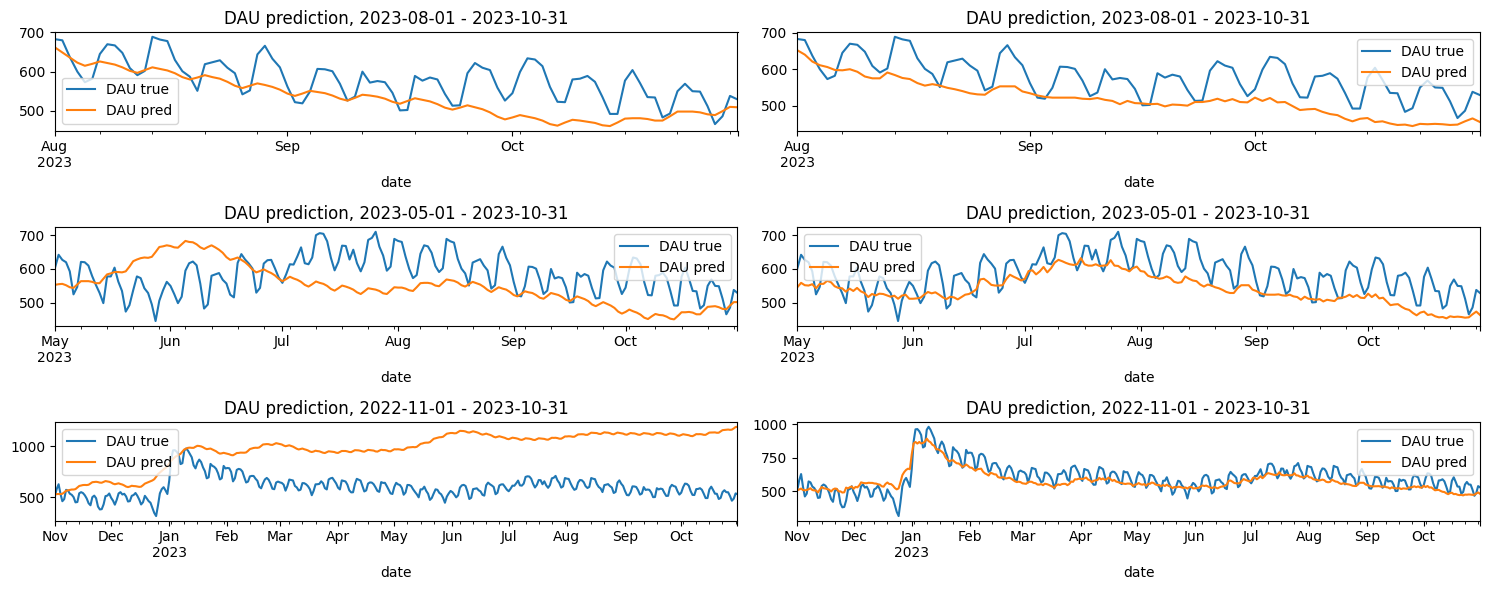

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(15, 6))
mapes = []
prediction_end = '2023-10-31'
prediction_horizon = [3, 6, 12]

for i, offset in enumerate(prediction_horizon):
    prediction_start = pd.to_datetime(prediction_end) - pd.DateOffset(months=offset - 1)
    prediction_start = prediction_start.replace(day=1)
    args = {
        'prediction_start': prediction_start,
        'prediction_end': prediction_end,
        'transition_period': 'last_365d'
    }
    for j, new_users_mode in enumerate(['predict', 'true']):
        args['new_users_mode'] = new_users_mode
        dau_pred = make_prediction(**args)
        mape = prediction_details(dau_true, dau_pred, ax=axs[i, j])
        mapes.append([offset, new_users_mode, mape])

mapes = pd.DataFrame(mapes, columns=['horizon', 'new_users', 'MAPE'])
plt.tight_layout()

The MAPE values summarizing the prediction quality:

In [26]:
mapes.pivot(index='horizon', columns='new_users', values='MAPE')

new_users,predict,true
horizon,,
3,0.085533,0.103631
6,0.125212,0.084652
12,0.650335,0.086885


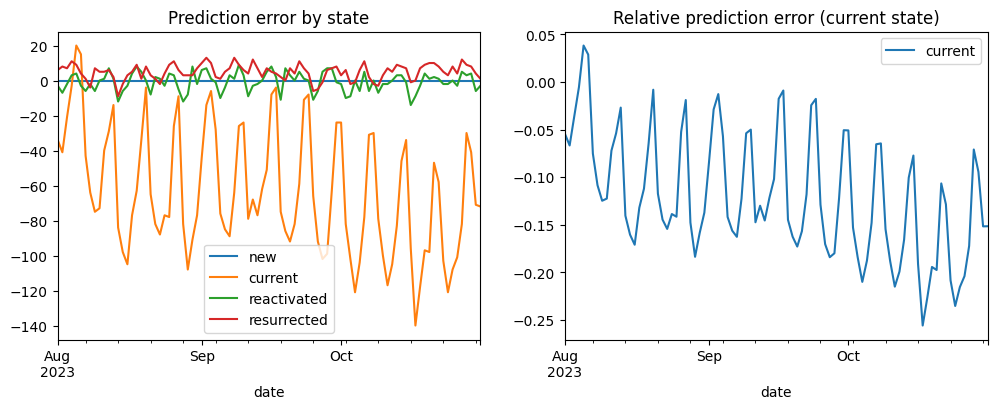

In [27]:
dau_component_cols = ['new', 'current', 'reactivated', 'resurrected']

dau_pred = make_prediction('2023-08-01', '2023-10-31', new_users_mode='true', transition_period='last_365d')
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

dau_pred[dau_component_cols]\
    .subtract(dau_true[dau_component_cols])\
    .reindex(dau_pred.index)\
    .plot(title='Prediction error by state', ax=ax1)

dau_pred[['current']]\
    .subtract(dau_true[['current']])\
    .div(dau_true[['current']])\
    .reindex(dau_pred.index)\
    .plot(title='Relative prediction error (current state)', ax=ax2);

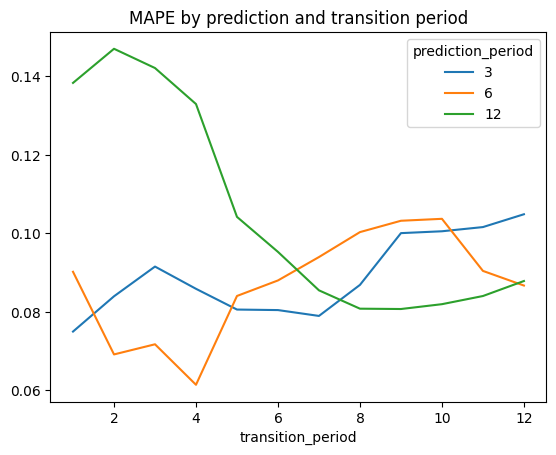

In [28]:
result = []

for prediction_offset in prediction_horizon:
    prediction_start = pd.to_datetime(prediction_end) - pd.DateOffset(months=prediction_offset - 1)
    prediction_start = prediction_start.replace(day=1)

    for transition_offset in range(1, 13):
        dau_pred = make_prediction(
            prediction_start, prediction_end, new_users_mode='true',
            transition_period=f'last_{transition_offset*30}d'
        )
        mape = prediction_details(dau_true, dau_pred, show_plot=False)
        result.append([prediction_offset, transition_offset, mape])
result = pd.DataFrame(result, columns=['prediction_period', 'transition_period', 'mape'])

result.pivot(index='transition_period', columns='prediction_period', values='mape')\
    .plot(title='MAPE by prediction and transition period');

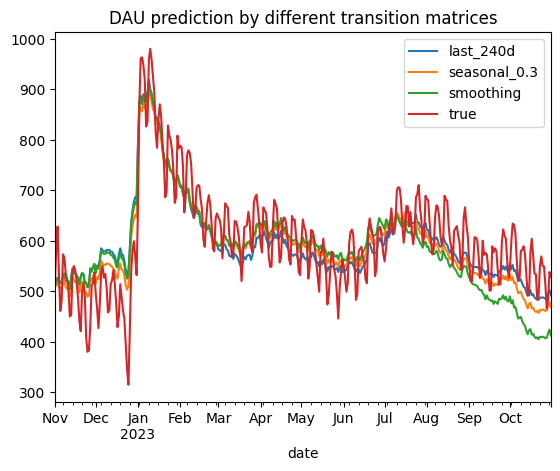

In [29]:
result = pd.DataFrame()
for transition_period in ['last_240d', 'seasonal_0.3', 'smoothing']:
    result[transition_period] = make_prediction(
        '2022-11-01', '2023-10-31',
        'true',
        transition_period
    )['dau']
result['true'] = dau_true['dau']
result['true'] = result['true'].astype(int)
result.plot(title='DAU prediction by different transition matrices');

In [30]:
mape = pd.DataFrame()
for col in result.columns:
    if col != 'true':
        mape.loc[col, 'mape'] = mean_absolute_percentage_error(result['true'], result[col])
mape

,mape
last_240d,0.080804
seasonal_0.3,0.077545
smoothing,0.097802


#### Final solution

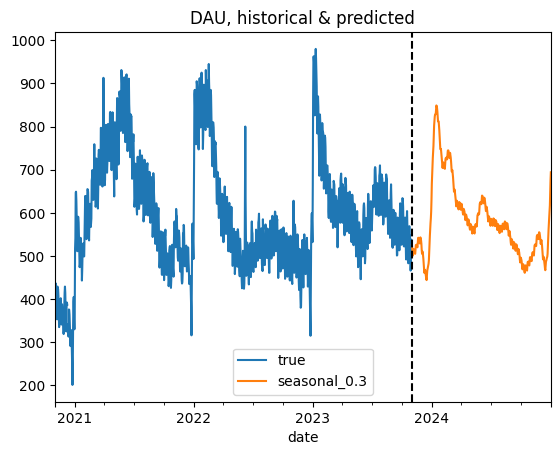

In [31]:
dau_pred = make_prediction(
    PREDICTION_START, PREDICTION_END,
    new_users_mode='predict',
    transition_period='seasonal_0.3'
)
dau_true['dau'].plot(label='true')
dau_pred['dau'].plot(label='seasonal_0.3')
plt.title('DAU, historical & predicted')
plt.axvline(PREDICTION_START, color='k', linestyle='--')
plt.legend();